# Far-Field and Near-Field Analysis

In [1]:
import sys
import os

sys.path.append('../') # Needed for import
import laserbeamtools as lbs

folder = r'../tests/test_beam_profiles/BES/BLE_22'



In [66]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle


class Beam_profile:

    def __init__(self,  img,
                        title='Original',
                        pixel_size=None,
                        units='µm',
                        crop=False,
                        cmap='gist_ncar',
                        corner_fraction=0.035,
                        nT=3,
                        iso_noise=True,
                        **kwargs
                        ):
        """
        Initalizes the beam profile object

        Args:

        """
        if pixel_size is None:
            self.scale = 1
            self.unit_str = ''
            self.units = 'pixels'
        else:
            self.scale = pixel_size
            self.unit_str = units
        self.img = img
        # Subtract background
        self.wimg = lbs.subtract_iso_background(self.img)
        # self.wimg = np.copy(img)
        self.title = title
        self.pixel_size = pixel_size
        self.units = units
        self.crop = crop
        self.cmap = cmap
        self.corner_fraction = corner_fraction
        self.nT = nT
        self.iso_noise = iso_noise
        self.bs_args = dict((k, kwargs[k]) for k in ['mask_diameters', 'max_iter', 'phi'] if k in kwargs)
        self.bs_args['iso_noise'] = iso_noise
        self.bs_args['nT'] = nT
        self.bs_args['corner_fraction'] = corner_fraction

        # Keep track of ran functions
        self.__ran_beam_size = False
        self.__ran_knife_edge = False

        # Init values
        self.kep = [0.05, 0.95]

        return

    def precrop(self, precrop_fraction=0.6) -> None:
        """
        Pre-crop the image before performing any data analysis.rst

        Args:
            frac: (optional) fraction to crop the image to.

        """
        # Check that the value is within  limits
        if precrop_fraction <= 0 or precrop_fraction > 0.9:
            raise ValueError('precrop_fraction must be positive and less than 0.9.')

        # Crop half width
        crop_frac_hw = precrop_fraction/2

        # Crop image
        vv,hh = self.img.shape
        vd = int(vv * crop_frac_hw)
        hd = int(hh * crop_frac_hw)
        self.wimg = self.img[vd:(vv-vd), hd:(hh-hd)]

        # Subtract background
        self.wimg = lbs.subtract_iso_background(self.wimg)

        return None

    def beam_size(self) -> None:
        """
        
        Args:

        """
        # Beam size
        self.x, self.y, self.dx, self.dy, self.phi = lbs.beam_size(self.wimg, **self.bs_args)

        # Scaled values
        self.vv,self.hh = self.wimg.shape
        self.v_s = self.vv * self.scale
        self.h_s = self.hh * self.scale
        self.x_s = self.x * self.scale
        self.y_s = self.y * self.scale
        self.dx_s = self.dx * self.scale
        self.dy_s = self.dy * self.scale
        self.major_s = np.max([self.dx_s, self.dy_s])
        self.minor_s = np.min([self.dx_s, self.dy_s])

        # Function ran
        self.__ran_beam_size = True

        return None

    def knife_edge(self, kep=[0.05,0.95], rotate=False) -> None:
        """
        
        Args:
            kep: (optional) fractional knife edge points, default is 5%-95%

        """
        # Run beam size if it hasn't been ran already
        if self.__ran_beam_size == False:
            self.beam_size()

        # Mask beam
        # mask = lbs.rotated_rect_mask(self.wimg, self.x, self.y, self.dx, self.dy, self.phi)
        
        # Working image
        self.mwimg = np.copy(self.wimg)
        
        # Apply mask
        # self.mwimg[mask < 0] = 0
        self.kep = kep
        # Rotated image
        if rotate:
            img_r = lbs.rotate_image(self.mwimg, self.x, self.y, -self.phi)
            x_r_, y_r_, dx_r_, dy_r_, _ = lbs.beam_size(img_r, **self.bs_args)
            img_r, _, _  = lbs.crop_image_to_integration_rect(img_r, x_r_, y_r_, dx_r_, dy_r_, 0)
            # x_r, y_r, dx_r, dy_r, phi_r = lbs.beam_size(img_r, **bs_args)
        else:
            img_r = np.copy(self.mwimg)
            x_r_, y_r_, dx_r_, dy_r_, _ = lbs.beam_size(img_r, **self.bs_args)
            img_r, _, _  = lbs.crop_image_to_integration_rect(img_r, x_r_, y_r_, dx_r_, dy_r_, self.phi)
            # x_r, y_r, dx_r, dy_r, phi_r = lbs.beam_size(img_r, **bs_args)

        # X knife-edge
        self.xax_ke_y, self.xax_ke_x, self.xkep = lbs.knife_edge(img_r, axis=0, kep=self.kep)
        self.xkep = self.xkep - np.average(self.xax_ke_x)
        self.xax_ke_x = self.xax_ke_x - np.average(self.xax_ke_x)

        # Y knife-edge
        self.yax_ke_y, self.yax_ke_x, self.ykep = lbs.knife_edge(img_r, axis=1, kep=self.kep)
        self.ykep = self.ykep - np.average(self.yax_ke_x)
        self.yax_ke_x = self.yax_ke_x - np.average(self.yax_ke_x)

        # Knife edge widths
        self.x_kew = (self.xkep[1]-self.xkep[0]) * self.scale
        self.y_kew = (self.ykep[1]-self.ykep[0]) * self.scale

        # Knife edge circularity
        self.circ = np.min([self.x_kew, self.y_kew]) / np.max([self.x_kew, self.y_kew])

        # Function ran
        self.__ran_knife_edge = True

        return None
    
    def gen_rotated(self):
        img_r = lbs.rotate_image(self.mwimg, self.x, self.y, -self.phi)
        x_r_, y_r_, dx_r_, dy_r_, _ = lbs.beam_size(img_r, **self.bs_args)
        img_r, _, _  = lbs.crop_image_to_integration_rect(img_r, x_r_, y_r_, dx_r_, dy_r_, 0)

        self.rotated = Beam_profile(img_r,
                        title=self.title+' Rotated',
                        pixel_size=self.pixel_size,
                        units=self.units,
                        crop=self.crop,
                        cmap=self.cmap,
                        **self.bs_args
                        )
        
        # self.rotated.beam_size()
        # self.rotated.knife_edge(kep=self.kep)
                                
        return




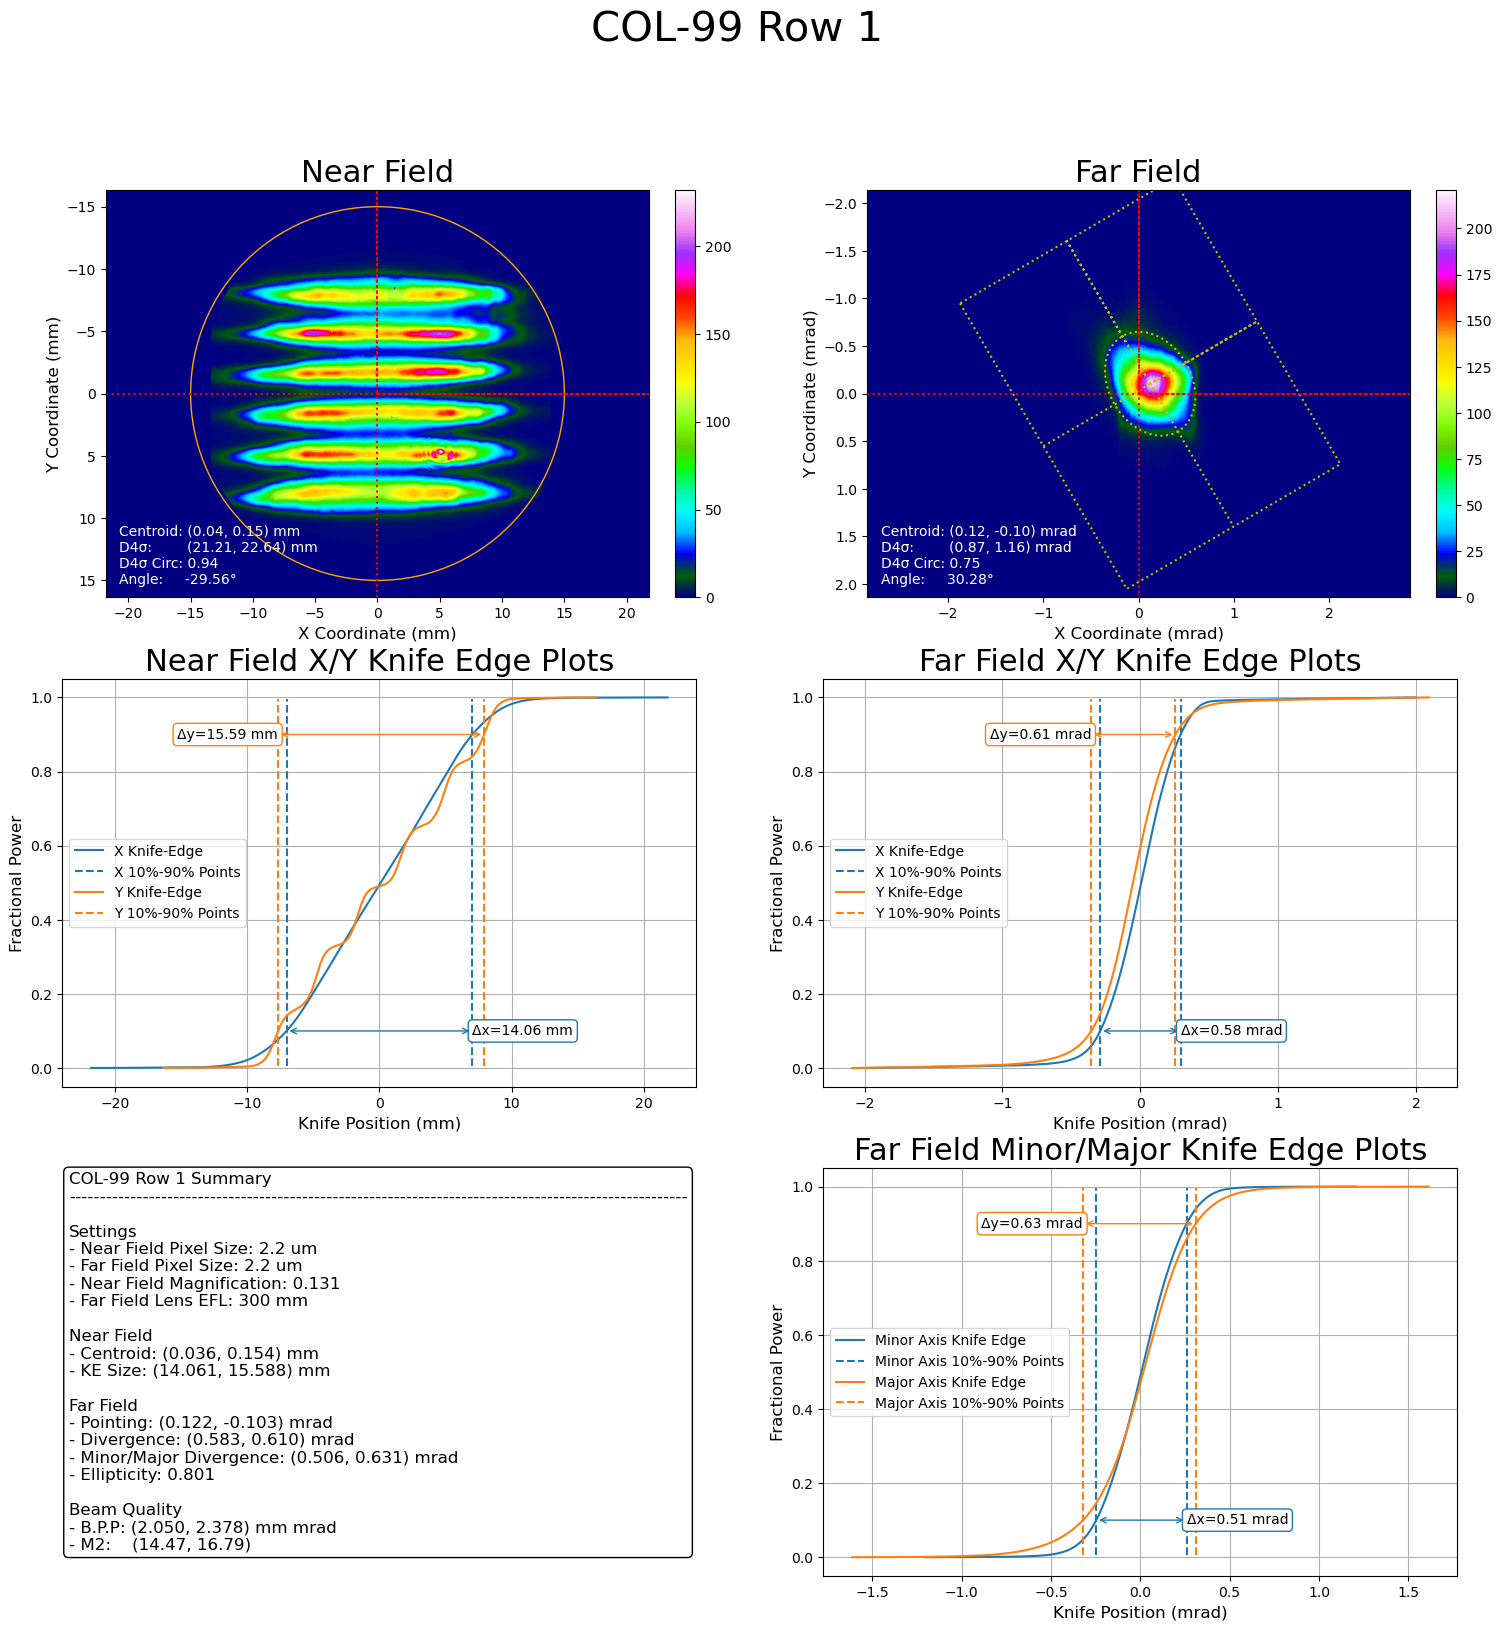

In [110]:
def near_and_far_profiles(nf_img, ff_img, title='COL-XX', nf_pixel_size=2.2, nf_mag=0.59, nf_scale_down=1000, nf_units='µm', ff_pixel_size=2.2, ff_lens=80, ff_units='mrad', kep=[0.10,0.90], precrop=0.7):
    """
    
    Args:

    """
    # small font size
    sf = 12
    
    # Create beam profile objects
    nf = Beam_profile(nf_img, title='Near Field', pixel_size=nf_pixel_size/(nf_mag*nf_scale_down), units=nf_units)
    ff = Beam_profile(ff_img, title='Far Field', pixel_size=(ff_pixel_size/ff_lens), units=ff_units)

    # Run calcs on objects
    ff.precrop(precrop)
    nf.beam_size()
    ff.beam_size()

    # Knife-edge objects
    nf.knife_edge(kep)
    ff.knife_edge(kep)

    # Rotated plots
    ff.gen_rotated()
    ff.rotated.beam_size()
    ff.rotated.knife_edge(kep)

    # Create subplots
    fig, axs = plt.subplots(3, 2, figsize=(18, 18))
    fig.suptitle(title, fontsize=30)

    for i, xf in enumerate([nf,ff]):

        # Plot image
        extent = np.array([-xf.h_s/2, xf.h_s/2, xf.v_s/2, -xf.v_s/2])
        im = axs[0,i].imshow(xf.wimg, extent=extent, cmap=xf.cmap) #, cmap='gist_ncar')
        plt.colorbar(im, ax=axs[0,i], fraction=0.046 * xf.v_s / xf.h_s, pad=0.04)

        if i == 1:
            # Rectangular array
            xp,yp = lbs.rotated_rect_arrays(xf.x, xf.y, xf.dx, xf.dy, xf.phi) * xf.scale
            axs[0,i].plot(xp-xf.h_s/2,yp-xf.v_s/2,':y')

            # Ellipse array
            xp,yp = lbs.ellipse_arrays(xf.x, xf.y, xf.dx, xf.dy, xf.phi) * xf.scale
            axs[0,i].plot(xp-xf.h_s/2,yp-xf.v_s/2,':y')

            # Axes array
            xp, yp = lbs.axes_arrays(xf.x, xf.y, xf.dx, xf.dy, xf.phi) * xf.scale
            axs[0,i].plot(xp-xf.h_s/2,yp-xf.v_s/2,':y')

        # Crosshair array
        xp, yp = lbs.axes_arrays(xf.hh/2, xf.vv/2, xf.hh/3, xf.vv/3, 0) * xf.scale
        axs[0,i].plot(xp-xf.h_s/2,yp-xf.v_s/2,':r')#,linewidth=1)

        # Plot formatting
        axs[0,i].set_title(xf.title, fontsize=22)
        axs[0,i].set_xlim(-xf.h_s/2, xf.h_s/2)
        axs[0,i].set_ylim(xf.v_s/2, -xf.v_s/2)
        axs[0,i].set_xlabel("X Coordinate (%s)" % xf.unit_str, fontsize=sf)
        axs[0,i].set_ylabel("Y Coordinate (%s)" % xf.unit_str, fontsize=sf)

        # Beam stats
        m1 = 'Centroid: (%.2f, %.2f) %s' % (xf.x*xf.scale - xf.h_s/2, xf.y*xf.scale - xf.v_s/2, xf.unit_str)
        m2 = 'D4\u03C3:        (%.2f, %.2f) %s' % (xf.dx_s, xf.dy_s, xf.unit_str)
        m3 = 'D4\u03C3 Circ: %.2f' % (xf.minor_s/xf.major_s)
        m4 = 'Angle:     %.2f\N{DEGREE SIGN}' % (xf.phi*180/np.pi)
        axs[0,i].text(-xf.h_s/2 * 0.95, xf.v_s/2*0.95, '\n'.join([m1,m2,m3,m4]), va='bottom', ha='left',c='white',fontsize=10)

        # Knife-edge plots x
        # --------------------------------------------- #
        axs[1,i].set_title(xf.title + ' X/Y Knife Edge Plots', fontsize=22)
        axs[1,i].set_xlabel("Knife Position (%s)" % xf.unit_str, fontsize=sf)
        axs[1,i].set_ylabel("Fractional Power", fontsize=sf)
        axs[1,i].grid('on')

        color = 'tab:blue'
        axs[1,i].plot(xf.xax_ke_x * xf.scale, xf.xax_ke_y, color=color, label='X Knife-Edge')
        
        # Plot lines
        axs[1,i].axvline(x=xf.xkep[0] * xf.scale, ymin=0.05, ymax=0.95, color=color, label='X {:.0f}%-{:.0f}% Points'.format(kep[0]*100, kep[1]*100), ls='--')
        axs[1,i].axvline(x=xf.xkep[1] * xf.scale, ymin=0.05, ymax=0.95, color=color, ls='--')

        # Show distance on plot
        x_w = (xf.xkep[1]-xf.xkep[0]) * xf.scale
        axs[1,i].annotate('', (xf.xkep[0] * xf.scale, kep[0]), (xf.xkep[1] * xf.scale, kep[0]), arrowprops=dict(arrowstyle= '<->',color=color))
        axs[1,i].text(np.average(xf.xkep[1]) * xf.scale, kep[0], 'Δx=%.2f %s' % (x_w, xf.unit_str), va='center', ha='left',
                      bbox=dict(facecolor='white', edgecolor=color, boxstyle='round'))

        # Knife-edge plots y
        # --------------------------------------------- #
        color = 'tab:orange'
        axs[1,i].plot(xf.yax_ke_x * xf.scale, xf.yax_ke_y, color=color, label='Y Knife-Edge')
        
        # Plot lines
        axs[1,i].axvline(x=xf.ykep[0] * xf.scale, ymin=0.05, ymax=0.95, color=color, label='Y {:.0f}%-{:.0f}% Points'.format(kep[0]*100, kep[1]*100), ls='--')
        axs[1,i].axvline(x=xf.ykep[1] * xf.scale, ymin=0.05, ymax=0.95, color=color, ls='--')

        y_w = (xf.ykep[1]-xf.ykep[0]) * xf.scale
        axs[1,i].annotate('', (xf.ykep[0] * xf.scale, kep[1]), (xf.ykep[1] * xf.scale, kep[1]), arrowprops=dict(arrowstyle= '<->',color=color))
        axs[1,i].text(np.average(xf.ykep[0]) * xf.scale, kep[1], 'Δy=%.2f %s' % (y_w, xf.unit_str), va='center', ha='right',
                      bbox=dict(facecolor='white', edgecolor=color, boxstyle='round'))

        # Knife-edge plot legend
        axs[1,i].legend(loc='center left')

    # Rotated Far Field Plot
    # =============================================== #
    axs[2,1].set_title(ff.title + ' Minor/Major Knife Edge Plots', fontsize=22)
    axs[2,1].set_xlabel("Knife Position (%s)" % ff.rotated.unit_str, fontsize=sf)
    axs[2,1].set_ylabel("Fractional Power", fontsize=sf)
    axs[2,1].grid('on')

    # Determine major or minor
    if ff.rotated.x_kew > ff.rotated.y_kew:
        xlabel = 'Major Axis'
        ylabel = 'Minor Axis'
    else:
        ylabel = 'Major Axis'
        xlabel = 'Minor Axis'

    color = 'tab:blue'
    axs[2,1].plot(ff.rotated.xax_ke_x * ff.rotated.scale, ff.rotated.xax_ke_y, color=color, label=xlabel + ' Knife Edge')
    
    arrowprops=dict(arrowstyle= '<|-|>',color='blue',lw=3.5,ls='--')
    # Plot lines
    axs[2,1].axvline(x=ff.rotated.xkep[0] * ff.rotated.scale, ymin=0.05, ymax=0.95, color=color, label=xlabel + ' {:.0f}%-{:.0f}% Points'.format(ff.kep[0]*100, ff.kep[1]*100), ls='--')
    axs[2,1].axvline(x=ff.rotated.xkep[1] * ff.rotated.scale, ymin=0.05, ymax=0.95, color=color, ls='--')

    # Show distance on plot
    axs[2,1].annotate('', (ff.rotated.xkep[0] * ff.rotated.scale, kep[0]), (ff.rotated.xkep[1] * ff.rotated.scale, ff.rotated.kep[0]), arrowprops=dict(arrowstyle= '<->',color=color))
    axs[2,1].text(np.average(ff.rotated.xkep[1]) * ff.rotated.scale, ff.rotated.kep[0], 'Δx=%.2f %s' % (ff.rotated.x_kew, ff.unit_str), va='center', ha='left',
                bbox=dict(facecolor='white', edgecolor=color, boxstyle='round'))

    color = 'tab:orange'
    axs[2,1].plot(ff.rotated.yax_ke_x * ff.rotated.scale, ff.rotated.yax_ke_y, color=color, label=ylabel + ' Knife Edge')
    
    # Plot lines
    axs[2,1].axvline(x=ff.rotated.ykep[0] * ff.rotated.scale, ymin=0.05, ymax=0.95, color=color, label=ylabel + ' {:.0f}%-{:.0f}% Points'.format(ff.kep[0]*100, ff.kep[1]*100), ls='--')
    axs[2,1].axvline(x=ff.rotated.ykep[1] * ff.rotated.scale, ymin=0.05, ymax=0.95, color=color, ls='--')

    axs[2,1].annotate('', (ff.rotated.ykep[0] * ff.rotated.scale, kep[1]), (ff.rotated.ykep[1] * ff.rotated.scale, kep[1]), arrowprops=dict(arrowstyle= '<->',color=color))
    axs[2,1].text(np.average(ff.rotated.ykep[0]) * ff.rotated.scale, kep[1], 'Δy=%.2f %s' % (ff.rotated.y_kew, ff.rotated.unit_str), va='center', ha='right',
                bbox=dict(facecolor='white', edgecolor=color, boxstyle='round'))
    
    # Legend
    axs[2,1].legend(loc='center left')

    # Near Field Circle
    circ = Circle((0,0),15, fc='None', edgecolor='orange')
    axs[0,0].add_patch(circ)
    # extent = np.array([-ff.h_s/2, ff.h_s/2, ff.v_s/2, -ff.v_s/2])
    # im = axs[0,1].imshow(ff.wimg, extent=extent, cmap=ff.cmap) #, cmap='gist_ncar')
    # plt.colorbar(im, ax=axs[0,1], fraction=0.046 * ff.v_s / ff.h_s, pad=0.04)

    operator = 'Ryan Robinson'
    summary_data = []
    l0 = title + ' Summary'
    l01 ='-----------------------------------------------------------------------------------------------------'

    s1 = '\nSettings'
    # s2 = 'Operator: %s' % operator
    # s3 = 'Directory: '
    # s4 = 'Run Date: '
    # s5 = 'Software Version: '
    s5 = '- Near Field Pixel Size: %.1f um' % nf_pixel_size
    s6 = '- Far Field Pixel Size: %.1f um' % ff_pixel_size
    s7 = '- Near Field Magnification: %.3f' % nf_mag
    s8 = '- Far Field Lens EFL: %.0f mm' % ff_lens


    l1 = '\nNear Field'
    l2 = '- Centroid: (%.3f, %.3f) %s' % (nf.x*nf.scale - nf.h_s/2, nf.y*nf.scale - nf.v_s/2, nf.unit_str)
    l3 = '- KE Size: (%.3f, %.3f) %s' % (nf.x_kew, nf.y_kew, nf.unit_str)

    lf1 = '\nFar Field'
    lf2 = '- Pointing: (%.3f, %.3f) %s' % (ff.x*ff.scale - ff.h_s/2, ff.y*ff.scale - ff.v_s/2, ff.unit_str)
    lf3 = '- Divergence: (%.3f, %.3f) %s' % (ff.x_kew, ff.y_kew, ff.unit_str)
    lf4 = '- Minor/Major Divergence: (%.3f, %.3f) %s' % (np.min([ff.rotated.x_kew, ff.rotated.y_kew]), np.max([ff.rotated.x_kew, ff.rotated.y_kew]), ff.rotated.unit_str)
    lf5 = '- Ellipticity: %.3f' % ff.rotated.circ

    lb1 = '\nBeam Quality'
    xbpp = (ff.x_kew * nf.x_kew) / 4
    ybpp = (ff.y_kew * nf.y_kew) / 4
    lb2 = '- B.P.P: (%.3f, %.3f) %s %s' % (xbpp, ybpp, nf.unit_str, ff.unit_str)
    ms = 7.06
    lb3 = '- M2:    (%.2f, %.2f)' % (xbpp*ms, ybpp*ms)

    s_data = [l0, l01, 
              s1, s5, s6, s7, s8, 
              l1, l2, l3, 
              lf1, lf2, lf3, lf4, lf5, 
              lb1, lb2, lb3]
    
    s_data_str = '\n'.join(s_data)

    axs[2,0].text(0.01, 0.99, s_data_str, va='top', ha='left', fontsize=12, bbox=dict(facecolor='None', edgecolor='black', boxstyle='round'))
    axs[2,0].axis('off')


    plt.savefig('test.png')
    plt.show()

    return


ff_img = lbs.load_img(folder+'/BE_All_FF.bmp')
nf_img = lbs.load_img(folder+'/BE_All_NF.bmp')

near_and_far_profiles(nf_img, ff_img, title='COL-99 Row 1', ff_lens=300, nf_mag=0.1307, nf_scale_down=1000, nf_units='mm')